In [6]:
import numpy as np
import pandas as pd
import re
import string
from collections import defaultdict
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# import mpld3
# from mpld3 import plugins
% matplotlib inline

In [7]:
# mpld3.enable_notebook() remove mpld3, because it doesn't show mail clusters in notebook preview

In [8]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
persons = pd.read_csv('hillary-clinton-emails/Persons.csv')
aliases = pd.read_csv('hillary-clinton-emails/Aliases.csv')

In [9]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

## Предобработка текста

Все тексты содержатся в колонках ExtractedBodyText и RawText. В ExtractedBodyText -- предобработанные создателями датасета тексты из RawText, но в них нет forward-ов и attachment-ов, поэтому лучше будем работать с текстами из колонки RawText, убрав из них заголовки писем и пометки US State Department, а также удалив пустые строки и пунктуацию.

In [10]:
raw_email_texts = emails['RawText'].dropna()

In [11]:
def remove_state_dept_info(email, axis):
    email = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', email)
    email = re.sub(r'UNCLASS.*?NO FOIA WAIVER\..(RELEASE IN.?(FULL|PART)?|STATE-\w+)?','',
                   email, flags=re.DOTALL)
    email = re.sub(r'^UNCLASSIFIED.*$', '', email, flags=re.MULTILINE)
    email = re.sub(r'^RELEASE IN (FULL|PART).*$', '', email, flags=re.MULTILINE)
    return email

In [12]:
def remove_email_header(email, axis):
    email = re.sub(r'^(From|Re|Sent|To|Cc|cc|CC|Importance|For|Attachments|Subject|Fw|Fwd).*$', '',
                   email, flags=re.MULTILINE)
    email = re.sub(r'B\d','',email)
    return email

In [13]:
def remove_empty_lines_and_punctuation(email, axis):
    email = '\n'.join([s for s in email.splitlines() if s])
    return ''.join([ch for ch in email if ch not in set(string.punctuation)])

In [14]:
email_texts_prepared = raw_email_texts.apply(remove_state_dept_info, axis=0)
email_texts_prepared = email_texts_prepared.apply(remove_email_header, axis=0)
email_texts_prepared = email_texts_prepared.apply(remove_empty_lines_and_punctuation, axis=0)

In [15]:
bigrams = defaultdict(int)
for email in email_texts_prepared:
    tokens = re.split(r'\s+', email)
    if len(tokens) > 1:
        token1, token2 = tokens[0], tokens[1]
        bigrams[(token1, token2)] += 1
        for token in tokens[2:]:
            token1 = token2
            token2 = token
            bigrams[(token1, token2)] += 1

In [16]:
sorted_bigrams = list(sorted(bigrams.items(), key=lambda x: -x[1]))

In [17]:
sorted_bigrams[:30]

[(('of', 'the'), 13497),
 (('in', 'the'), 9082),
 (('Original', 'Message'), 7190),
 (('to', 'the'), 6197),
 (('on', 'the'), 4716),
 (('and', 'the'), 4060),
 (('for', 'the'), 3854),
 (('that', 'the'), 3546),
 (('with', 'the'), 3084),
 (('to', 'be'), 2977),
 (('at', 'the'), 2526),
 (('will', 'be'), 2357),
 (('by', 'the'), 2289),
 (('the', 'US'), 2172),
 (('is', 'a'), 2083),
 (('from', 'the'), 2055),
 (('United', 'States'), 1894),
 (('of', 'a'), 1828),
 (('the', 'United'), 1762),
 (('as', 'a'), 1754),
 (('has', 'been'), 1711),
 (('in', 'a'), 1638),
 (('is', 'the'), 1454),
 (('would', 'be'), 1418),
 (('for', 'a'), 1396),
 (('it', 'is'), 1353),
 (('as', 'the'), 1307),
 (('have', 'been'), 1239),
 (('want', 'to'), 1236),
 (('of', 'State'), 1235)]

In [18]:
all_words = []
for email in email_texts_prepared:
    tokens = re.split(r'\s+', email)
    all_words.extend([token for token in tokens if len(token) > 0])

In [19]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(all_words)
finder.apply_freq_filter(120)

In [20]:
finder.nbest(bigram_measures.pmi, 30) 

[('Sinn', 'Fein'),
 ('AGIS', 'DoS'),
 ('OFFICE', 'TIME'),
 ('DAS', 'AGIS'),
 ('Human', 'Rights'),
 ('Source', 'Comment'),
 ('Saudi', 'Arabia'),
 ('per', 'cent'),
 ('Northern', 'Ireland'),
 ('Lona', 'Valmoro'),
 ('Private', 'Residence'),
 ('Sullivan', 'Jacob'),
 ('SECRETARY', 'CLINTON'),
 ('Class', 'CONFIDENTIAL'),
 ('Reason', '14B'),
 ('prime', 'minister'),
 ('En', 'route'),
 ('D', 'MillsCDstategov'),
 ('Jacob', 'J'),
 ('14B', '14D'),
 ('Street', 'NW'),
 ('Tea', 'Party'),
 ('Tony', 'Blair'),
 ('Middle', 'East'),
 ('civil', 'society'),
 ('North', 'Korea'),
 ('West', 'Bank'),
 ('Special', 'Assistant'),
 ('Operations', 'Center'),
 ('sensitive', 'source')]

In [21]:
vectorizer = TfidfVectorizer(max_features=2000,stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(email_texts_prepared.values)

In [22]:
names = vectorizer.get_feature_names()

In [23]:
k_means = KMeans(n_clusters=3)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
pred_labels = k_means.predict(X)

In [25]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X.todense())

In [26]:
for class_label in range(3):
    print('Class {}:'.format(class_label))
    class_members = email_texts_prepared.values[pred_labels==class_label]
    chosen = np.random.choice(np.arange(class_members.shape[0]))
    print(class_members[chosen])

Class 0:
RELEASE IN
FULL
800 am DEPART Private Residence En route Washington Convention Center
820 am ARRIVE Washington Convention Center
830 am BILATERAL wPM HSIEN LOONG LEE SINGAPORE
845 am S Bilateral Room 148 Washington Convention Center Camera spray at top
900 am BILATERAL wFM MOURAD MEDELCI ALGERIA
915 am S Bilateral Room 148 Washington Convention Center Camera spray at top
930 am MORNING SESSION OF THE NUCLEAR SECURITY SUMMIT
1130 am Plenary Room Washington Convention Center
1000 am BILATERAL wTURKISH FM DAVUTOGLU
1030 am S Bilateral Room 148 Washington Convention Center Camera spray at top
1045 am BILATERAL wEGYPTIAN FM ABOUL GHEIT
1115 am S Bilateral Room 148 Washington Convention Center Camera spray at top
1115 am BILATERAL wFM TAIEB FASSIFIHRI MOROCCO
1130 am S Bilateral Room 148 Washington Convention Center Camera spray at top
1140 am BILATERAL wFOREIGN MINISTER KASIT THAILAND
1200 pm S Bilateral Room 148 Washington Convention Center Camera spray at top
1200 pm COHOST WORKI

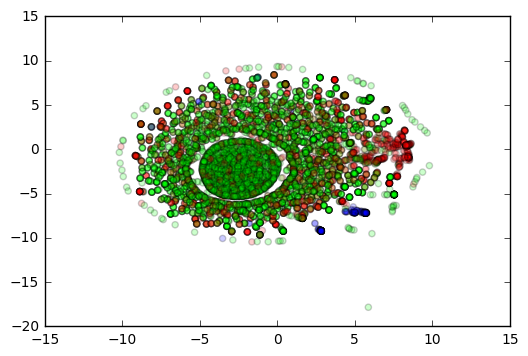

In [27]:
color_dict = plt.cm.brg(np.linspace(0., 1., 3))
fig = plt.figure()
points = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=color_dict[pred_labels], alpha=0.2)
# print(points.shape)
# tooltip = plugins.PointHTMLTooltip(points, labels=list(map(str,pred_labels)))
# plugins.connect(fig, tooltip)

plt.show()

Тут явно выделился синий кластер с расписаниями, "ядро" образуют зеленые письма про внешнюю политику США и красные письма - это всякие организационные вопросы (кстати они заметно смещены к расписаниям).

## Оценка качества кластеризации
Для оценки качества кластеризации можно попробовать посмотреть насколько письма в разных кластерах отличаются друг от друга. Асессорам можно выдавать по 3 письма: 2 из одного кластера, а одно из другого. Если большинство асессоров выделяют третье письмо как лишнее, значит эти 2 кластера хорошо разделимы. Аналогично можно делать с 3 письмами из одного кластера - если выбор асессоров больше похож на рандомное угадывание, то значит этот кластер сложно разделить на подкластеры.